In [80]:
# Params
# we verify on a smaller ring for convenience
f = 32
N0 = f / 2
N_TRIALS = 1000000          # per-q iterations
MODE = "gcd"               # "gcd" or "inverse"
MODE_SPLIT = "FS"          # "FS" or "ALF"
K_RANGE = range(6, 23)    # k=10..30
MAX_TRIES = 1_000_000

from time import perf_counter
import random
import matplotlib.pyplot as plt

# Precompute cyclotomic polynomial over ZZ
Phi_ZZ = cyclotomic_polynomial(f)
deg_expected = euler_phi(f)  # 128

def make_rng(seed):
    return random.Random(seed)

VALS = (-1, 0, 1)

def find_q_near_power_of_two(k, N0, max_tries=MAX_TRIES):
    target = Integer(2)**k
    q = target
    for t in range(1, max_tries + 1):
        q -= 1
        if not q.is_prime():
            continue
        m = q - 1
        if MODE_SPLIT == "FS":
            # fully splitting: q ≡ 1 (mod 256)
            if m % (2 * N0) == 0:
                return Integer(q), t
        else:  # "ALF": almost fully splitting: q ≡ 1 (mod 128) but not mod 256
            if m % N0 != 0:
                continue
            if m % (2 * N0) == 0:
                continue
            return Integer(q), t
    return None, max_tries

def run_experiment(q, N=N_TRIALS, mode=MODE, seed=None):
    R.<x> = Zmod(q)[]
    Phi = R(Phi_ZZ)
    D = Phi.degree()
    if D != deg_expected:
        print(f"Warning: deg(Phi)={D}, expected {deg_expected}")

    rng = make_rng(seed)

    # Sample c directly as difference of two ternary vectors
    def diff_poly(D):
        a = rng.choices(VALS, k=D)
        b = rng.choices(VALS, k=D)
        return R([ai - bi for ai, bi in zip(a, b)])

    invertible = 0
    t_gen = 0.0
    t_check = 0.0
    t_total_start = perf_counter()

    for _ in range(N):
        g0 = perf_counter()
        c = diff_poly(D)
        t_gen += perf_counter() - g0

        c0 = perf_counter()
        try:
            if mode == "inverse":
                _ = c.inverse_mod(Phi)
                invertible += 1
            else:
                if gcd(c, Phi).degree() == 0:
                    invertible += 1
        except Exception:
            pass
        t_check += perf_counter() - c0

    t_total = perf_counter() - t_total_start

    # Expected non-invertible rate, by factorization pattern:
    # FS: 128 linear factors → 1 - (1 - 1/q)^128
    # ALF: 64 quadratic factors → 1 - (1 - 1/q^2)^64
    if MODE_SPLIT == "FS":
        expected_rate = float(1 - (1 - 1/float(q))**deg_expected)
    else:  # "ALF"
        expected_rate = float(1 - (1 - 1/float(q*q))**(deg_expected // 2))

    return {
        "q": int(q),
        "log2q": float(log(q, 2)),
        "deg": int(D),
        "N": N,
        "invertible": int(invertible),
        "rate": float(1 - invertible / N),     # measured non-invertible rate
        "expected_rate": expected_rate,        # theoretical curve
        "t_total": t_total,
        "t_gen": t_gen,
        "t_check": t_check,
    }

# Sweep q ~ 2^k
results = []
for k in K_RANGE:
    base = Integer(2)**k
    q, steps = find_q_near_power_of_two(k, N0)
    if q is None:
        print(f"k={k}, 2^k={base}: no suitable prime found in {MAX_TRIES} steps")
        continue

    print(f"k={k}, 2^k={base}, q={q} (found after {steps} steps)")
    stats = run_experiment(q, N=N_TRIALS, mode=MODE, seed=None)
    print(f"  inv {stats['invertible']:>6}/{stats['N']}  "
          f"rate={stats['rate']:.6e}  expected_rate={stats['expected_rate']:.6e}  "
          f"time={stats['t_total']:.2f}s  gen={stats['t_gen']:.2f}s  check={stats['t_check']:.2f}s")
    if stats['rate'] == 0:
        break
    results.append(stats)

# Summary print
print("\nSummary:")
for s in results:
    print(f"q={s['q']:>10}  log2q={s['log2q']:.3f}  "
          f"rate={s['rate']:.6e}  expected={s['expected_rate']:.6e}  "
          f"t={s['t_total']:.2f}s  gen={s['t_gen']:.2f}s  check={s['t_check']:.2f}s")



k=6, 2^k=64: no suitable prime found in 1000000 steps
k=7, 2^k=128, q=97 (found after 31 steps)
  inv 847131/1000000  rate=1.528690e-01  expected_rate=1.527882e-01  time=10.01s  gen=6.73s  check=1.82s
k=8, 2^k=256, q=193 (found after 63 steps)
  inv 920742/1000000  rate=7.925800e-02  expected_rate=7.975659e-02  time=10.02s  gen=6.71s  check=1.83s
k=9, 2^k=512, q=449 (found after 63 steps)
  inv 965181/1000000  rate=3.481900e-02  expected_rate=3.504565e-02  time=10.41s  gen=7.06s  check=1.87s
k=10, 2^k=1024, q=929 (found after 95 steps)
  inv 982925/1000000  rate=1.707500e-02  expected_rate=1.708447e-02  time=10.39s  gen=7.06s  check=1.88s
k=11, 2^k=2048, q=2017 (found after 31 steps)
  inv 991994/1000000  rate=8.006000e-03  expected_rate=7.903145e-03  time=10.38s  gen=7.02s  check=1.91s
k=12, 2^k=4096, q=4001 (found after 95 steps)
  inv 996021/1000000  rate=3.979000e-03  expected_rate=3.991513e-03  time=10.51s  gen=7.12s  check=1.94s
k=13, 2^k=8192, q=8161 (found after 31 steps)
  inv

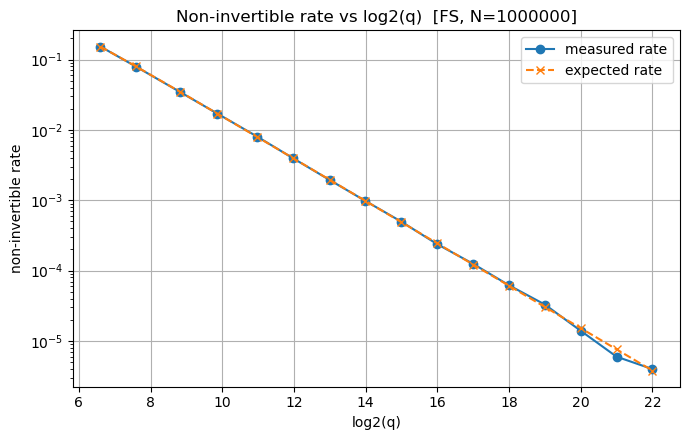

In [81]:
# for fully-splitting

xs = [s["log2q"] for s in results]
ys_meas = [s["rate"] for s in results]
ys_exp = [s["expected_rate"] for s in results]

plt.figure(figsize=(7,4.5))
plt.plot(xs, ys_meas, marker="o", label="measured rate")
plt.plot(xs, ys_exp, marker="x", linestyle="--", label="expected rate")
plt.xlabel("log2(q)")
plt.ylabel("non-invertible rate")
plt.yscale("log")
plt.title(f"Non-invertible rate vs log2(q)  [{MODE_SPLIT}, N={N_TRIALS}]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

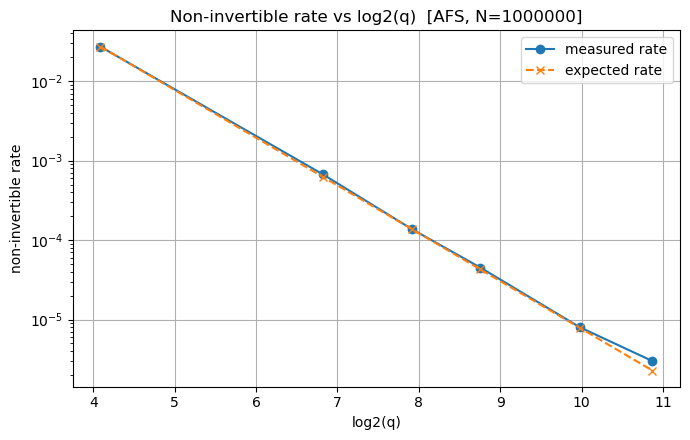

In [79]:
# for almost-fully-splitting

xs = [s["log2q"] for s in results]
ys_meas = [s["rate"] for s in results]
ys_exp = [s["expected_rate"] for s in results]

plt.figure(figsize=(7,4.5))
plt.plot(xs, ys_meas, marker="o", label="measured rate")
plt.plot(xs, ys_exp, marker="x", linestyle="--", label="expected rate")
plt.xlabel("log2(q)")
plt.ylabel("non-invertible rate")
plt.yscale("log")
plt.title(f"Non-invertible rate vs log2(q)  [{MODE_SPLIT}, N={N_TRIALS}]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()